# Capstone: Predicting IPL outcomes

# Notebook 3: Modeling and prediction

## Project summary

Sports betting is a billion-dollar industry. Cricket betting, albeit small compared to football or baseball, was still valued at USD10 billion annually with a further USD40 to USD50 billion in [illegal bets](http://www.espncricinfo.com/pakistan/content/story/535250.html) (often from India and Pakistan where betting is banned). Models that can consistently predict outcomes and beat the odds of bookmakers can therefore have great value.

This project aims to predict the outcome of Indian Premier League (IPL) matches. The IPL, a professional Twenty20 cricket league in India, is the richest tournament in cricket. It is contested annually in April and May. While the teams represent Indian cities (and in some cases a state), it attracts the best players from around the (cricket-playing) world.

The rules of cricket can seem quite involved, this [link](https://www.youtube.com/watch?v=AqtpNkMvj5Y) provides a 5 minute introduction 

The bulk of the data is available from a Kaggle [dataset](https://www.kaggle.com/manasgarg/ipl/data) which includes ball-by-ball information for each of the games between 2008 - 2017 (636 games in total) as well as a separate database with match level information. 

## Notebook 3: Summary
 This project uses four algorithms to predict IPL matches. Since the outcome variable is binary, this is a classification problem. I use logistic regression, random forest classifiers, xgboost, and neural networks (a simple multilayer perceptron as well as a sequential dense model).<br>
The benchmark to beat, set by bookie performance (here taken as the team with the lowest payout) is 55%. Unfortunately, beating this benchmark doesn’t guarantee millions to be made in the betting world. Each bookie uses slightly different odds (we use an aggregate) and charges different rates (given as a percentage of payouts). These rates can be anywhere from 90 per cent (expensive) to 98 per cent (cheaper, mainly for big matches with a large betting pool).
The algorithms are run on three variations of the dataset which is broadly the outline of the notebook below:<br>
1.	**Section 1: Setting up the data.** Before applying the algorithms the dataset, processed and adapted in Notebook 1 and visualized in Notebook 2, is reshaped and processed one last time. Categorical variables (the season, teams playing and the home team) is changed into one hot encoding (dummy variables) and bowling strike rates are removed (as they are highly correlated with bowling averages). The dummy variables substantially expand the feature set to 57. Given that I only have 557 samples, there is a risk of overfitting, particularly in the logistic regression algorithm which has stronger assumptions that the rest of the algorithms<br>
2.	 **Section 2: Using the full feature set**<br>
3.	**Section 3: Reducing the feature set** The cross validation results from Section 2 indicate that there is some overfitting in the models. This may be due to the combination of small sample size and large feature set. To attempt to negate some of this the feature set is reduced, first through PCA and then through a manual process.<br>
4.	**Section 4: Using the bookies** The aim of this model is to beat the bookies. However, the bookies odds themselves contain valuable information. The odds can contain many factors that are not available to the current models. This can include team performance (e.g. momentum), injuries to key players, or under/overperformance of players not captured in the aggregate team statistics. The data is taken from [Oddsportal]( http://www.oddsportal.com/cricket/india/ipl/results/). To match this data to the existing dataset requires several adjustments. The odds are only available from 2010 onwards and are missing for certain games, thus the sample size is reduced to 370. The betting data is given as home-away odds, which also means many of the features need to be adjusted to match this configuration.<br>

The results are shown in the table below. The bookies provide a useful benchmark. The odds for each team are compared and the team with the lowest payout is assumed to be the bookmakers’ pick. **Using this method the bookies’ had an accuracy of 55% over 370 games.**

In [262]:
print(summary.round(2)) 

             Accuracy  Precision  Recall    f1
Logit            0.62       0.62    0.63  0.62
rf               0.62       0.64    0.64  0.62
xgc              0.62       0.60    0.61  0.60
mlp              0.62       0.66    0.65  0.61
seq_nn           0.75       0.75    0.76  0.74
rf_pca           0.70       0.67    0.66  0.67
logit_pca        0.68       0.67    0.68  0.67
xgc_pca          0.79       0.77    0.78  0.78
rf_small         0.65       0.66    0.60  0.58
logit_small      0.60       0.59    0.60  0.59
mlp_pca          0.66       0.63    0.62  0.63
seq_pca          0.68       0.67    0.68  0.67
Logit_bets       0.65       0.64    0.61  0.60
rf_bets          0.62       0.68    0.55  0.49
xgc_bets         0.59       0.58    0.57  0.57
mlp_bets         0.59       0.56    0.55  0.55
seq_nn_bets      0.62       0.61    0.60  0.60


Using the full feature set already achieves good results. All the models have accuracy rates over 60%, beating the (simple) bookies prediction by 5%. However, in cross validation the models show signs of overfitting.

The PCA adjusted models performed surprisingly well. PCA was only performed on eight of the variables (all the different team statistics), reducing it down to four features. Accuracy improved in all the models, and the cross-validation results were more stable (the random forest classifier performed particularly well).

Manually reducing the feature (calculating the difference between team statistics and dropping season dummies) set did not improve the results. Importantly, it also didn’t improve the stability of the model as cross-validation still showed that the models were overfitting.

Finally, adding the odds data from the bookies only improved the accuracy of the logit model. Including the odds data is probably the most promising avenue – it can contain lots of additional information which are not readily available through features (e.g. player form, injuries, weather, and team dynamics). However, in this case more than 100 samples couldn’t be matched to odds data, which further reduced the (already small) sample size. Given that the model was already overfitting this was always going to be a problem. The random forest classifier however, was surprisingly stable, but with weaker accuracy than the PCA model.


**Conclusion** This project has shown that it is possible to predict the outcome of an IPL cricket match. While the accuracy is still relatively low (it is a sport after all – it’s unpredictability is what makes it great), models can outperform a benchmark set by the bookmaker’s odds. This does not mean that the model is ready to be used as a betting tool. The betting world is a lot more complicated (many bookmakers each offering different odds and charging different prices) and the model is still too inconsistent.

The model can be improved in many ways, cleaner betting odds (currently behind a paywall) will help, as will data from the 2018 season. This model could arguably also be extended to other tournaments (e.g. the Australian Big Bash) to increase the sample size. A key next step would also be to ensure that the team statistics data isn’t leaky, by using the performance of players’ in previous seasons (or at least excluding games which are in the test set).


# Section 1: Setting up the data (one last time)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
% matplotlib inline
import seaborn as sns

In [117]:
games = pd.read_csv('matches_updated.csv')

In [263]:
y = games.loc[:, 'team1_win']

# Get dummies #CITY?
games['season'] = games.season.apply(str)
dummies = pd.get_dummies(games.loc[:, ['season', 'team1', 'team2', 'home_team']])

# Drop variables that won't be used
games_small = games.drop(['id', 'season', 'city', 'date', 'team1', 'team2', 'toss_winner',
                          'toss_decision', 'result', 'winner', 'team1_win',
                          'win_by_runs', 'win_by_wickets', 'player_of_match', 'venue', 
                          'team2_win', 'home_team', 'toss_winner_id', 'winner_id', 
                          'runs_1st', 'runs_2nd', 'wickets_1st', 'wickets_2nd',
                         'team1_total_runs', 'team2_total_runs',
                         'team1_id', 'team2_id', 'home_team_id',
                         'bat_1st', 'bat_2nd'], axis=1)
# Join dfs
X = pd.concat([games_small, dummies], axis=1)

In [264]:
X.columns

Index(['team1_bat_avg', 'team2_bat_avg', 'team1_bat_strike',
       'team2_bat_strike', 'team1_bowl_avg', 'team2_bowl_avg',
       'team1_bowl_strike', 'team2_bowl_strike', 'team1_bowl_econ',
       'team2_bowl_econ', 'season_2008', 'season_2010', 'season_2011',
       'season_2012', 'season_2013', 'season_2014', 'season_2015',
       'season_2016', 'season_2017', 'team1_Chennai Super Kings',
       'team1_Deccan Chargers', 'team1_Delhi Daredevils',
       'team1_Gujarat Lions', 'team1_Kings XI Punjab',
       'team1_Kochi Tuskers Kerala', 'team1_Kolkata Knight Riders',
       'team1_Mumbai Indians', 'team1_Pune Warriors', 'team1_Rajasthan Royals',
       'team1_Rising Pune Supergiants', 'team1_Royal Challengers Bangalore',
       'team1_Sunrisers Hyderabad', 'team2_Chennai Super Kings',
       'team2_Deccan Chargers', 'team2_Delhi Daredevils',
       'team2_Gujarat Lions', 'team2_Kings XI Punjab',
       'team2_Kochi Tuskers Kerala', 'team2_Kolkata Knight Riders',
       'team2_Mumbai

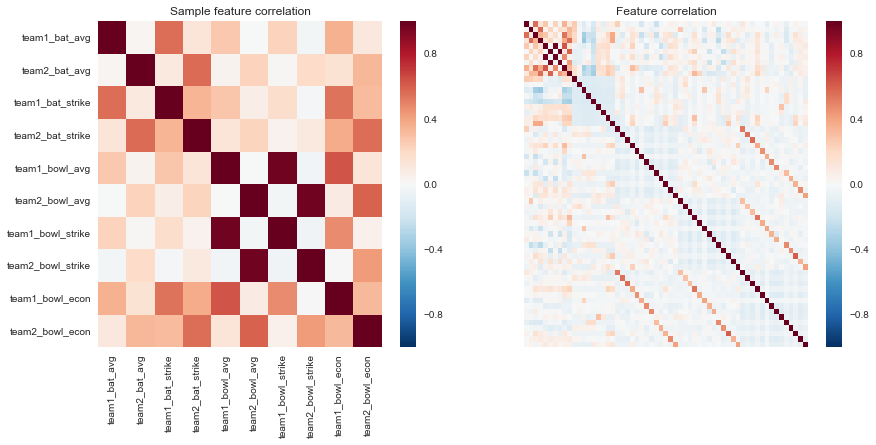

In [12]:
corr = X.corr()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.tight_layout
corr_small = X.iloc[:, 0:10].corr()
sns.heatmap(corr_small)
plt.title('Sample feature correlation')

plt.subplot(1,2,2)
sns.heatmap(corr, xticklabels=False, yticklabels=False)
plt.ylabel('')    
plt.xlabel('')
plt.title('Feature correlation')
plt.show()

In [265]:
# Drop team1_bowl_strike and team2_bowl_strike due to correlation with avg
X.drop(['team1_bowl_strike', 'team2_bowl_strike'], axis=1, inplace=True)

In [266]:
from sklearn import model_selection

# Split randomly into train and test (possibly unbalanced accross seasons)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

## The benchmark: Bookie odds

In [15]:
bets = pd.read_excel('IPL_betting_data.xlsx')

# df is a copy of matches, but two additional columns, only interested in these
bets = bets.loc[:, ['team1', 'team2', 'winner', 'home_favorite', 'bookies_correct']]

# Bookies data is based off home game
# Note: Favourite team classified as one with lower payout
# However, in games df some matches are classed as 'No home game'
# These are dropped, along with 2008 (no historical betting data)
bets.dropna(inplace=True)

# This is our baseline performance
bookie_correct = bets.bookies_correct.sum() / len(bets)*100
print('Bookies correctly predicted {} per cent of {} games'.format(round(bookie_correct, 2), len(bets)))

Bookies correctly predicted 55.41 per cent of 370 games


# Section 2: Using the full feature set

### Logistic regression

In [48]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection

params = {'penalty': ['l1', 'l2'],
          'C': [0.001, 0.01, 0.1, 1, 10],
          'class_weight': [None, 'balanced'],
         }

# Initialize the model
logit = linear_model.LogisticRegression()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(logit, params)

# Fit to data
grid.fit(X_train, y_train)

# For use in CV later
logit_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test)[:,1]
y_hat = grid.predict(X_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)          

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Accuracy is: 0.625

             precision    recall  f1-score   support

Team1 loses       0.71      0.61      0.66        66
 Team1 wins       0.54      0.65      0.59        46

avg / total       0.64      0.62      0.63       112


team1_win   0   1
row_0            
0          40  16
1          26  30


In [56]:
for i, var in enumerate(X.columns):
    print(var, round(logit_best.coef_[0][i],4))

team1_bat_avg 0.0012
team2_bat_avg -0.0462
team1_bat_strike 0.0285
team2_bat_strike -0.0203
team1_bowl_avg -0.0214
team2_bowl_avg 0.0307
team1_bowl_econ -0.0041
team2_bowl_econ 0.0062
season_2008 0.0005
season_2010 0.003
season_2011 -0.0014
season_2012 -0.0001
season_2013 -0.0014
season_2014 -0.0037
season_2015 0.0037
season_2016 -0.0042
season_2017 0.0033
team1_Chennai Super Kings 0.0055
team1_Deccan Chargers -0.0001
team1_Delhi Daredevils -0.0006
team1_Gujarat Lions -0.0022
team1_Kings XI Punjab -0.0042
team1_Kochi Tuskers Kerala -0.0003
team1_Kolkata Knight Riders 0.0009
team1_Mumbai Indians 0.0039
team1_Pune Warriors -0.0018
team1_Rajasthan Royals -0.0028
team1_Rising Pune Supergiants -0.0008
team1_Royal Challengers Bangalore -0.0021
team1_Sunrisers Hyderabad 0.0042
team2_Chennai Super Kings -0.0016
team2_Deccan Chargers 0.0034
team2_Delhi Daredevils 0.0025
team2_Gujarat Lions -0.0023
team2_Kings XI Punjab 0.0016
team2_Kochi Tuskers Kerala 0.0001
team2_Kolkata Knight Riders -0.0033

The regularization means that the coefficients aren't striclty the log-odds ratios and this doesn't show p-values or confidence intervals. What it does show is that the batting and bowling stats have the expected signs.

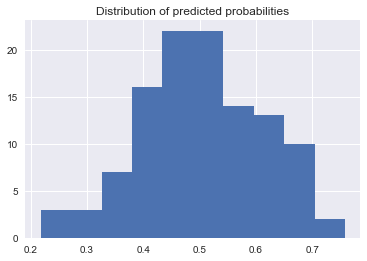

In [35]:
plt.hist(y_prob)
plt.title('Distribution of predicted probabilities')
plt.show()

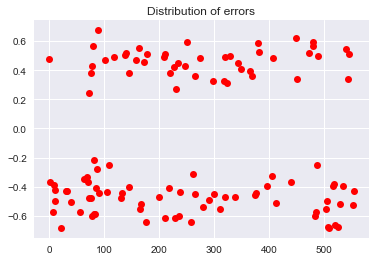

In [36]:
errors = y_test - y_prob
plt.plot(errors, 'ro')
plt.title('Distribution of errors')
plt.show()

In [37]:
# Cross validate using best estimator
print(model_selection.cross_val_score(logit_best, X, y, cv = 8))

[0.67142857 0.61428571 0.6        0.51428571 0.67142857 0.69565217
 0.57971014 0.55072464]


In [38]:
# For summary
compare = {}

compare['Logit'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

### Random Forest Classifier

In [39]:
from sklearn import ensemble

params = {'n_estimators': [10, 50, 100],
          'max_depth': [None, 1, 2, 5],
          'random_state': [10],
          'class_weight': [None, 'balanced'],
          'min_samples_leaf': [1, 5, 10]
         }

# Initialising and fitting the model
rf = ensemble.RandomForestClassifier()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(rf, params)

# Fit to data
grid.fit(X_train, y_train)

# For use in CV later
rf_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test)[:,1]
y_hat = grid.predict(X_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=1, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

Accuracy is: 0.616

             precision    recall  f1-score   support

Team1 loses       0.76      0.52      0.61        66
 Team1 wins       0.52      0.76      0.62        46

avg / total       0.66      0.62      0.62       112


team1_win   0   1
row_0            
0          34  11
1          32  35


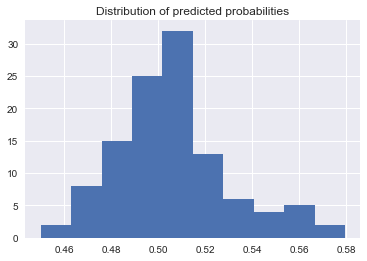

In [40]:
plt.hist(y_prob)
plt.title('Distribution of predicted probabilities')
plt.show()

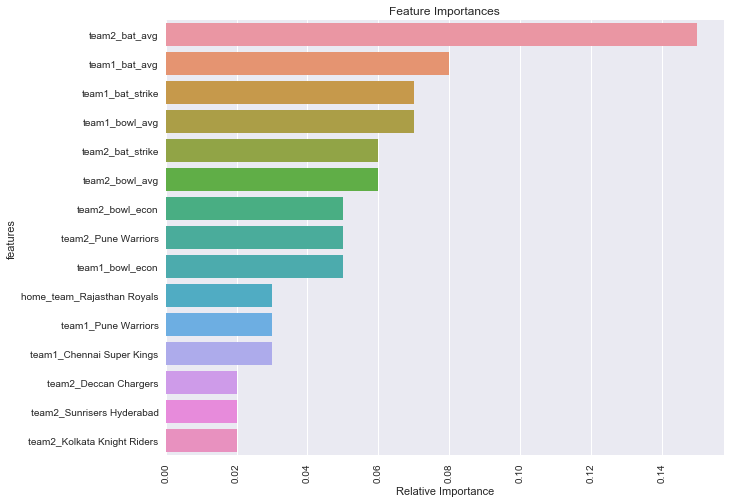

In [41]:
features = list(X.columns)
importances = rf_best.feature_importances_

feature_imp = pd.DataFrame({'features':features, 'importance':importances})
feature_imp.sort_values(by='importance', inplace=True, ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(y = feature_imp.features[0:15], x = feature_imp.importance[0:15], orient="h")
#plt.yticks(fontsize=16)
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

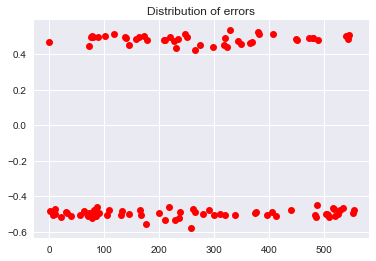

In [42]:
errors = y_test - y_prob
plt.plot(errors, 'ro')
plt.title('Distribution of errors')
plt.show()

In [43]:
# CV using best estimator
print(model_selection.cross_val_score(rf_best, X, y, cv = 10))

[0.66666667 0.66666667 0.56140351 0.53571429 0.50909091 0.61818182
 0.67272727 0.61818182 0.58181818 0.54545455]


In [44]:
compare['rf'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

## Xgboost

In [45]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

params = {#'eta': [0.1, 0.2, 0.3],
          #'min_child_weight': [1, 2, 5],
          'max_depth': [1, 2, 3],
          'gamma': [0, 0.3, 1],
          'subsample': [0.6, 0.8, 1.0],
          'objective': ['binary:logistic']
         }

# Initialize
xgc = xgb.XGBClassifier()


# Apply GridSearch to the model
grid = model_selection.GridSearchCV(xgc, params)

# Fit to data
grid.fit(X_train, y_train)

# For use in CV later
xgc_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test)[:,1]
y_hat = grid.predict(X_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Ana

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1.0)

Accuracy is: 0.616

             precision    recall  f1-score   support

Team1 loses       0.68      0.67      0.67        66
 Team1 wins       0.53      0.54      0.54        46

avg / total       0.62      0.62      0.62       112


team1_win   0   1
row_0            
0          44  21
1          22  25


In [46]:
compare['xgc'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [47]:
# CV using best estimator
print(model_selection.cross_val_score(xgc_best, X, y, cv = 10))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[0.64912281 0.63157895 0.52631579 0.60714286 0.54545455 0.65454545
 0.63636364 0.61818182 0.6        0.54545455]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Neural networks

### Multi-layer Perceptron Classifier

In [69]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model.
# Reduce iterations to 200
mlp = MLPClassifier(hidden_layer_sizes=(57), max_iter=100)

mlp.fit(X_train, y_train)

print("Train score: %0.3f" % mlp.score(X_train, y_train))

#Fit to test
y_hat = mlp.predict(X_test)

print("Accuracy is: %0.3f" % mlp.score(X_test, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

Train score: 0.613
Accuracy is: 0.616

             precision    recall  f1-score   support

Team1 loses       0.79      0.47      0.59        66
 Team1 wins       0.52      0.83      0.64        46

avg / total       0.68      0.62      0.61       112


team1_win   0   1
row_0            
0          31   8
1          35  38


In [70]:
compare['mlp'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [71]:
from sklearn.neural_network import MLPClassifier

#CV
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    Xs_train, Xs_test = X.iloc[train_index], X.iloc[test_index]
    ys_train, ys_test = y.iloc[train_index], y.iloc[test_index]
    mlp = MLPClassifier(hidden_layer_sizes=(81), max_iter=100)
    mlp.fit(Xs_train, ys_train)
    y_hat = mlp.predict(Xs_test)
    cross = pd.crosstab(y_hat, ys_test)
    print(cross)
    #acc = (cross[0][0]+cross[1][1])/len(y_hat)
    sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
    count += 1
    print('Sensitivity for fold {} is {}'.format(count, round(sensitive,3)))
    print("Accuracy is: %0.3f" % mlp.score(Xs_test, ys_test))
    print('')


team1_win   0   1
row_0            
0          57  37
1           4  14
Sensitivity for fold 1 is 0.275
Accuracy is: 0.634

team1_win   0   1
row_0            
0          46  31
1          15  20
Sensitivity for fold 2 is 0.392
Accuracy is: 0.589

team1_win   0   1
row_0            
0          44  26
1          17  25
Sensitivity for fold 3 is 0.49
Accuracy is: 0.616

team1_win   0   1
row_0            
0          38  29
1          23  21
Sensitivity for fold 4 is 0.42
Accuracy is: 0.532

team1_win   0   1
row_0            
0          46  33
1          14  17
Sensitivity for fold 5 is 0.34
Accuracy is: 0.573



### Sequential NN

In [175]:
from keras import optimizers
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GRU, Embedding
from keras.layers import LSTM, Input, TimeDistributed, SimpleRNN
from keras.models import Model
from keras.optimizers import RMSprop

# First have to create train, validation and test set
# Easiest is to split twice
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = model_selection.train_test_split(X_test, y_test,
                                                                test_size = 0.5, random_state=42)

model = Sequential()
model.add(Dense(57, activation='relu', input_shape=(len(X.columns),)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Fitting model (note adjusting matrix to avoid 0)
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=200,
                    verbose=0,
                    validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 57)                3306      
_________________________________________________________________
dropout_43 (Dropout)         (None, 57)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 32)                1856      
_________________________________________________________________
dropout_44 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 33        
Total params: 5,195
Trainable params: 5,195
Non-trainable params: 0
_________________________________________________________________


In [176]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: %0.3f' % score[0])
print('Test accuracy: %0.3f' % score[1])

y_hat = model.predict_classes(X_test)

56/56 [==============================] - 0s 304us/step
Test loss: 0.626
Test accuracy: 0.750


In [177]:
compare['seq_nn'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [179]:
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    Xs_train, Xs_test = X.iloc[train_index], X.iloc[test_index]
    ys_train, ys_test = y.iloc[train_index], y.iloc[test_index]
    # create model
    model = Sequential()
    model.add(Dense(57, activation='relu', input_shape=(len(X.columns),)))
    # Dropout layers remove features and fight overfitting
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    # End with a number of units equal to the number of classes we have for our outcome
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
    # Fit the model
    model.fit(Xs_train, ys_train, epochs=200, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xs_test, ys_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    

acc: 55.36%
acc: 58.04%
acc: 56.25%
acc: 54.05%
acc: 50.00%


# Reducing the feature set

In [188]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition

# Split the datasets to continuous and dummy vars
X_train_small = X_train.loc[:, 'team1_bat_avg':'team2_bowl_econ']
X_test_small = X_test.loc[:, 'team1_bat_avg':'team2_bowl_econ']
dummy_train = X_train.loc[:, 'season_2008':'home_team_Sunrisers Hyderabad']
dummy_train.reset_index(inplace=True, drop=True)
dummy_test = X_test.loc[:, 'season_2008':'home_team_Sunrisers Hyderabad']
dummy_test.reset_index(inplace=True, drop=True)

# Create standard scaler
scaler = preprocessing.StandardScaler()
# Fit and transform
X_train_small = scaler.fit_transform(X_train_small)
# Only transform - no peeking!
X_test_small = scaler.transform(X_test_small)

# Create PCA instance
pca = decomposition.PCA(4)
# Fit and transform
X_train_small = pca.fit_transform(X_train_small)
# Fit only
X_test_small = pca.transform(X_test_small)

print(pca.explained_variance_ratio_)

# Hacking everything back into dfs
X_train_pca = pd.DataFrame(data=X_train_small[:,:],
                           index=range(len(X_train_small)),
                           columns=['pca1', 'pca2', 'pca3', 'pca4'])
X_test_pca = pd.DataFrame(data=X_test_small[:,:],
                           index=range(len(X_test_small)),
                           columns=['pca1', 'pca2', 'pca3', 'pca4'])

# Join dfs
X_train_pca = pd.concat([X_train_pca, dummy_train], axis=1)
X_test_pca = pd.concat([X_test_pca, dummy_test], axis=1)

[0.37027788 0.21777928 0.12086249 0.11235417]


## Logit with PCA

In [193]:
params = {'penalty': ['l1', 'l2'],
          'C': [0.001, 0.01, 0.1, 1, 10],
          'class_weight': [None, 'balanced'],
         }

# Initialize the model
logit = linear_model.LogisticRegression()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(logit, params)

# Fit to data
grid.fit(X_train_pca, y_train)

# For use in CV later
logit_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test_pca)[:,1]
y_hat = grid.predict(X_test_pca)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test_pca, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)          

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy is: 0.679

             precision    recall  f1-score   support

Team1 loses       0.77      0.69      0.73        35
 Team1 wins       0.56      0.67      0.61        21

avg / total       0.69      0.68      0.68        56


team1_win   0   1
row_0            
0          24   7
1          11  14


In [194]:
compare['logit_pca'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [195]:
# Cross validate using best estimator
print(model_selection.cross_val_score(logit_best, X, y, cv = 8))

[0.62857143 0.58571429 0.55714286 0.55714286 0.65714286 0.69565217
 0.56521739 0.53623188]


## Random forest with PCA

In [196]:
from sklearn import ensemble
from sklearn import metrics

params = {'n_estimators': [10, 50, 100],
          'max_depth': [1, 2],
          'random_state': [10],
          'class_weight': [None, 'balanced'],
          'min_samples_leaf': [1, 5, 10]
         }

# Initialising and fitting the model
rf = ensemble.RandomForestClassifier()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(rf, params)

# Fit to data
grid.fit(X_train_pca, y_train)

# For use in CV later
rf_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test_pca)[:,1]
y_hat = grid.predict(X_test_pca)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test_pca, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

Accuracy is: 0.696

             precision    recall  f1-score   support

Team1 loses       0.74      0.80      0.77        35
 Team1 wins       0.61      0.52      0.56        21

avg / total       0.69      0.70      0.69        56


team1_win   0   1
row_0            
0          28  10
1           7  11


In [197]:
compare['rf_pca'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [198]:
# CV using best estimator
print(model_selection.cross_val_score(rf_best, X, y, cv = 10))

[0.54385965 0.59649123 0.56140351 0.51785714 0.56363636 0.54545455
 0.6        0.54545455 0.54545455 0.54545455]


## Xgboost with PCA

In [199]:
params = {#'eta': [0.1, 0.2, 0.3],
          #'min_child_weight': [1, 2, 5],
          'max_depth': [1, 2, 3],
          'gamma': [0, 0.3, 1],
          'subsample': [0.6, 0.8, 1.0],
          'objective': ['binary:logistic']
         }

# Initialize
xgc = xgb.XGBClassifier()


# Apply GridSearch to the model
grid = model_selection.GridSearchCV(xgc, params)

# Fit to data
grid.fit(X_train_pca, y_train)

# For use in CV later
xgc_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test_pca)[:,1]
y_hat = grid.predict(X_test_pca)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test_pca, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Accuracy is: 0.786

             precision    recall  f1-score   support

Team1 loses       0.85      0.80      0.82        35
 Team1 wins       0.70      0.76      0.73        21

avg / total       0.79      0.79      0.79        56


team1_win   0   1
row_0            
0          28   5
1           7  16


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [200]:
compare['xgc_pca'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [201]:
# CV using best estimator
print(model_selection.cross_val_score(xgc_best, X, y, cv = 10))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[0.61403509 0.57894737 0.61403509 0.58928571 0.58181818 0.58181818
 0.58181818 0.6        0.54545455 0.54545455]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Neural networks

### MLP

In [202]:
mlp = MLPClassifier(hidden_layer_sizes=(53), max_iter=100)

mlp.fit(X_train_pca, y_train)

print("Train score: %0.3f" % mlp.score(X_train_pca, y_train))

#Fit to test
y_hat = mlp.predict(X_test_pca)

print("Accuracy is: %0.3f" % mlp.score(X_test_pca, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

Train score: 0.760
Accuracy is: 0.661

             precision    recall  f1-score   support

Team1 loses       0.71      0.77      0.74        35
 Team1 wins       0.56      0.48      0.51        21

avg / total       0.65      0.66      0.65        56


team1_win   0   1
row_0            
0          27  11
1           8  10


C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [203]:
compare['mlp_pca'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [204]:
#CV
count = 0
skf = model_selection.StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    Xs_train, Xs_test = X.iloc[train_index], X.iloc[test_index]
    ys_train, ys_test = y.iloc[train_index], y.iloc[test_index]
    mlp = MLPClassifier(hidden_layer_sizes=(81), max_iter=100)
    mlp.fit(Xs_train, ys_train)
    y_hat = mlp.predict(Xs_test)
    #acc = (cross[0][0]+cross[1][1])/len(y_hat)
    sensitive = cross[1][1]/(cross[1][0]+cross[1][1])
    count += 1
    print('Sensitivity for fold {} is {}'.format(count, round(sensitive,3)))
    print("Accuracy is: %0.3f" % mlp.score(Xs_test, ys_test))

Sensitivity for fold 1 is 0.476
Accuracy is: 0.571
Sensitivity for fold 2 is 0.476
Accuracy is: 0.557
Sensitivity for fold 3 is 0.476
Accuracy is: 0.600
Sensitivity for fold 4 is 0.476
Accuracy is: 0.529
Sensitivity for fold 5 is 0.476
Accuracy is: 0.543
Sensitivity for fold 6 is 0.476
Accuracy is: 0.493
Sensitivity for fold 7 is 0.476
Accuracy is: 0.667
Sensitivity for fold 8 is 0.476
Accuracy is: 0.565


### Sequential

In [205]:
# Not using a validation set for this one


model = Sequential()
model.add(Dense(53, activation='relu', input_shape=(len(X_train_pca.columns),)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Fitting model (note adjusting matrix to avoid 0)
history = model.fit(X_train_pca, y_train,
                    batch_size=128,
                    epochs=200,
                    verbose=0
                   )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 53)                2862      
_________________________________________________________________
dropout_67 (Dropout)         (None, 53)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 32)                1728      
_________________________________________________________________
dropout_68 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 33        
Total params: 4,623
Trainable params: 4,623
Non-trainable params: 0
_________________________________________________________________


In [206]:
score = model.evaluate(X_test_pca, y_test, verbose=1)
print('Test loss: %0.3f' % score[0])
print('Test accuracy: %0.3f' % score[1])

y_hat = model.predict_classes(X_test_pca)

56/56 [==============================] - 1s 23ms/step
Test loss: 0.834
Test accuracy: 0.679


In [207]:
compare['seq_pca'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [208]:
count = 0
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    Xs_train, Xs_test = X.iloc[train_index], X.iloc[test_index]
    ys_train, ys_test = y.iloc[train_index], y.iloc[test_index]
    # create model
    model = Sequential()
    model.add(Dense(57, activation='relu', input_shape=(len(X.columns),)))
    # Dropout layers remove features and fight overfitting
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    # End with a number of units equal to the number of classes we have for our outcome
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
    # Fit the model
    model.fit(Xs_train, ys_train, epochs=200, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xs_test, ys_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    

acc: 62.50%
acc: 57.14%
acc: 59.82%
acc: 57.66%
acc: 54.55%


## Manually reduce features

In [268]:
# Reduce stats for each team into difference of stat
X['bat_avg_dif'] = X.team1_bat_avg - X.team2_bat_avg
X['bat_strike_dif'] = X.team1_bat_strike - X.team2_bat_strike
X['bowl_avg_dif'] = X.team1_bowl_avg - X.team2_bowl_avg
X['bowl_econ_dif'] = X.team1_bowl_econ - X.team2_bowl_econ

# Drop old stats + season features 
X.drop(['team1_bat_avg', 'team2_bat_avg', 'team1_bat_strike',
        'team2_bat_strike', 'team1_bowl_avg', 'team2_bowl_avg',
        'team1_bowl_econ', 'team2_bowl_econ', 'season_2008',
        'season_2011', 'season_2012', 'season_2013', 'season_2014',
        'season_2015', 'season_2016','season_2017'],
       axis=1, inplace=True)

# Split randomly into train and test (possibly unbalanced accross seasons)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

## Logit with smaller feature set

In [269]:
params = {'penalty': ['l1', 'l2'],
          'C': [0.001, 0.01, 0.1, 1, 10],
          'class_weight': [None, 'balanced'],
         }

# Initialize the model
logit = linear_model.LogisticRegression()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(logit, params)

# Fit to data
grid.fit(X_train, y_train)

# For use in CV later
logit_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test)[:,1]
y_hat = grid.predict(X_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy is: 0.598

             precision    recall  f1-score   support

Team1 loses       0.68      0.61      0.64        66
 Team1 wins       0.51      0.59      0.55        46

avg / total       0.61      0.60      0.60       112


team1_win   0   1
row_0            
0          40  19
1          26  27


In [270]:
compare['logit_small'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [271]:
print(model_selection.cross_val_score(logit_best, X, y, cv = 10))

[0.52631579 0.68421053 0.52631579 0.57142857 0.54545455 0.63636364
 0.70909091 0.63636364 0.61818182 0.49090909]


## Random forest with manually reduced feature set

In [272]:
params = {'n_estimators': [10, 50, 100],
          'max_depth': [1, 2],
          'random_state': [10],
          'class_weight': [None, 'balanced'],
          'min_samples_leaf': [1, 5, 10]
         }

# Initialising and fitting the model
rf = ensemble.RandomForestClassifier()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(rf, params)

# Fit to data
grid.fit(X_train, y_train)

# For use in CV later
rf_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(X_test)[:,1]
y_hat = grid.predict(X_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(X_test, y_test))
print('')
print(metrics.classification_report(y_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, y_test)
print('')
print(cross)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

Accuracy is: 0.661

             precision    recall  f1-score   support

Team1 loses       0.67      0.85      0.75        66
 Team1 wins       0.64      0.39      0.49        46

avg / total       0.66      0.66      0.64       112


team1_win   0   1
row_0            
0          56  28
1          10  18


In [273]:
compare['rf_small'] = [metrics.accuracy_score(y_test, y_hat),
                     metrics.precision_score(y_test, y_hat, average = 'macro'),
                     metrics.recall_score(y_test, y_hat, average = 'macro'),
                     metrics.f1_score(y_test, y_hat, average = 'macro')]

In [275]:
# CV using best estimator
print(model_selection.cross_val_score(rf_best, X, y, cv = 10))

[0.56140351 0.54385965 0.54385965 0.625      0.50909091 0.67272727
 0.67272727 0.54545455 0.6        0.50909091]


# Section 4: Using the bookies

In [220]:
# Using betting df, keeping only relevants features
bets = pd.read_excel('IPL_betting_data.xlsx')
bets = bets.loc[:, ['id', 'home_odds', 'away_odds', 'home_team', 'away_team', 'home_win', 'home_is_team1']]


# Redo above but keep id
game_bets = games.drop(['date', 'team1', 'team2', 'toss_winner',
                          'toss_decision', 'result', 'winner', 'team1_win',
                          'win_by_runs', 'win_by_wickets', 'player_of_match', 'venue', 
                          'team2_win', 'home_team', 'toss_winner_id', 'winner_id', 
                          'runs_1st', 'runs_2nd', 'wickets_1st', 'wickets_2nd',
                         'team1_total_runs', 'team2_total_runs',
                         'team1_id', 'team2_id', 'home_team_id',
                         'bat_1st', 'bat_2nd', 'team1', 'team2'], axis=1)

# Merge datasets
bet = pd.merge(game_bets, bets, on='id', how='left')


# Create new dummies (note city included) 
dummies = pd.get_dummies(bet.loc[:, ['city', 'season', 'home_team', 'away_team']])

# Join dummies
X_bets = pd.concat([bet, dummies], axis=1)

# Drop dummy sources
X_bets.drop(['id', 'city', 'season', 'home_team', 
             'away_team', 'team1_bowl_strike', 'team2_bowl_strike'], axis=1, inplace=True)

# Some missing data (2008 + 'no home game')
X_bets.dropna(inplace=True)



def team_align(home_or_away, home_is_team1, team1_stat, team2_stat):
    ''' Matches home team with team 1 or two
    Returns appropriate stats for specified team team'''
    if home_or_away=='home':
        if home_is_team1==1:
            return team1_stat
        else:
            return team2_stat
    elif home_or_away=='away':
        if home_is_team1==1:
            return team2_stat
        else:
            return team1_stat

# Team1 and team2 not used here, so have to rework to home and away teams
# Use home_is_team1 var in bets

X_bets['home_bat_avg'] = X_bets.apply(lambda x: team_align('home', x.home_is_team1,
                                                           x.team1_bat_avg, x.team2_bat_avg), axis=1)
X_bets['away_bat_avg'] = X_bets.apply(lambda x: team_align('away', x.home_is_team1,
                                                           x.team1_bat_avg, x.team2_bat_avg), axis=1)

X_bets['home_bat_strike'] = X_bets.apply(lambda x: team_align('home', x.home_is_team1,
                                                           x.team1_bat_strike, x.team2_bat_strike), axis=1)
X_bets['away_bat_strike'] = X_bets.apply(lambda x: team_align('away', x.home_is_team1,
                                                           x.team1_bat_strike, x.team2_bat_strike), axis=1)

X_bets['home_bowl_avg'] = X_bets.apply(lambda x: team_align('home', x.home_is_team1,
                                                           x.team1_bowl_avg, x.team2_bowl_avg), axis=1)
X_bets['away_bowl_avg'] = X_bets.apply(lambda x: team_align('away', x.home_is_team1,
                                                           x.team1_bowl_avg, x.team2_bowl_avg), axis=1)

X_bets['home_bowl_econ'] = X_bets.apply(lambda x: team_align('home', x.home_is_team1,
                                                           x.team1_bowl_econ, x.team2_bowl_econ), axis=1)
X_bets['away_bowl_econ'] = X_bets.apply(lambda x: team_align('away', x.home_is_team1,
                                                           x.team1_bowl_econ, x.team2_bowl_econ), axis=1)

# Now drop all the old variables
X_bets.drop(['team1_bat_avg', 'team2_bat_avg', 'team1_bat_strike', 'team2_bat_strike',
             'team1_bowl_avg', 'team2_bowl_avg', 'team1_bowl_econ', 'team2_bowl_econ', 'home_is_team1'],
            axis=1, inplace=True)

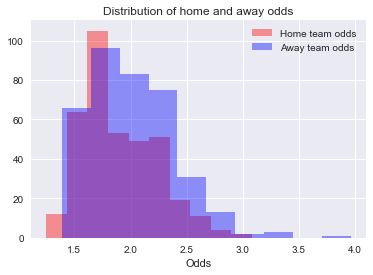

In [221]:
#plt.hist(total, alpha = 0.4, color = 'b')
plt.hist(X_bets.loc[:, 'home_odds'], alpha = 0.4, color = 'r', label = 'Home team odds',)
plt.hist(X_bets.loc[:, 'away_odds'], alpha = 0.4, color = 'b', label = 'Away team odds')
plt.legend()
plt.xlabel('Odds')
plt.title('Distribution of home and away odds')
plt.show()

In [222]:
# Create new y
y_b = X_bets.loc[:, 'home_win']

# Drop from X
X_bets.drop(['home_win'], axis=1, inplace=True)


# Split randomly into train and test (possibly unbalanced accross seasons)
Xb_train, Xb_test, yb_train, yb_test = model_selection.train_test_split(X_bets, y_b, test_size=0.30, random_state=13)

## Logit

In [223]:
params = {'penalty': ['l1', 'l2'],
          'C': [0.001, 0.01, 0.1, 1, 10],
          'class_weight': [None, 'balanced'],
         }

# Initialize the model
logit = linear_model.LogisticRegression()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(logit, params)

# Fit to data
grid.fit(Xb_train, yb_train)

# For use in CV later
logit_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(Xb_test)[:,1]
y_hat = grid.predict(Xb_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(Xb_test, yb_test))
print('')
print(metrics.classification_report(yb_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, yb_test)
print('')
print(cross)          

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy is: 0.649

             precision    recall  f1-score   support

Team1 loses       0.63      0.37      0.47        46
 Team1 wins       0.65      0.85      0.74        65

avg / total       0.64      0.65      0.63       111


home_win   0   1
row_0           
0         17  10
1         29  55


In [224]:
# Cross validate using best estimator
print(model_selection.cross_val_score(logit_best, X_bets, y_b, cv = 8))

[0.57446809 0.4893617  0.61702128 0.5        0.67391304 0.7173913
 0.63043478 0.55555556]


In [226]:
compare['Logit_bets'] = [metrics.accuracy_score(yb_test, y_hat),
                     metrics.precision_score(yb_test, y_hat, average = 'macro'),
                     metrics.recall_score(yb_test, y_hat, average = 'macro'),
                     metrics.f1_score(yb_test, y_hat, average = 'macro')]

## Random forest

In [231]:
params = {'n_estimators': [10, 50, 100],
          'max_depth': [None, 1, 2],
          'random_state': [10],
          'class_weight': [None, 'balanced'],
          'min_samples_leaf': [1, 5, 10]
         }

# Initialising and fitting the model
rf = ensemble.RandomForestClassifier()

# Apply GridSearch to the model
grid = model_selection.GridSearchCV(rf, params)

# Fit to data
grid.fit(Xb_train, yb_train)

# For use in CV later
rf_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(Xb_test)[:,1]
y_hat = grid.predict(Xb_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(Xb_test, yb_test))
print('')
print(metrics.classification_report(yb_test, y_hat,
                                    target_names=['Home loses', 'Home wins']))
cross = pd.crosstab(y_hat, yb_test)
print('')
print(cross)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

Accuracy is: 0.622

             precision    recall  f1-score   support

 Home loses       0.75      0.13      0.22        46
  Home wins       0.61      0.97      0.75        65

avg / total       0.67      0.62      0.53       111


home_win   0   1
row_0           
0          6   2
1         40  63


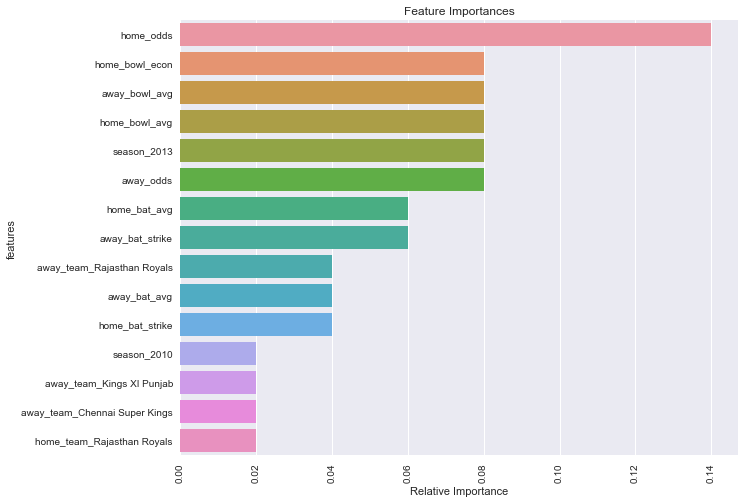

In [228]:
features = list(X_bets.columns)
importances = rf_best.feature_importances_

feature_imp = pd.DataFrame({'features':features, 'importance':importances})
feature_imp.sort_values(by='importance', inplace=True, ascending=False)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
sns.barplot(y = feature_imp.features[0:15], x = feature_imp.importance[0:15], orient="h")
#plt.yticks(fontsize=16)
plt.xlabel('Relative Importance')
plt.xticks(rotation=90)
plt.show()

In [229]:
compare['rf_bets'] = [metrics.accuracy_score(yb_test, y_hat),
                     metrics.precision_score(yb_test, y_hat, average = 'macro'),
                     metrics.recall_score(yb_test, y_hat, average = 'macro'),
                     metrics.f1_score(yb_test, y_hat, average = 'macro')]

In [230]:
# Cross validate using best estimator
print(model_selection.cross_val_score(rf_best, X_bets, y_b, cv = 8))

[0.57446809 0.55319149 0.55319149 0.56521739 0.56521739 0.58695652
 0.58695652 0.6       ]


## Xgboost

In [232]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

params = {#'eta': [0.1, 0.2, 0.3],
          #'min_child_weight': [1, 2, 5],
          'max_depth': [1, 2, 3],
          'gamma': [0, 0.3, 1],
          'subsample': [0.6, 0.8, 1.0],
          'objective': ['binary:logistic']
         }

# Initialize
xgc = xgb.XGBClassifier()


# Apply GridSearch to the model
grid = model_selection.GridSearchCV(xgc, params)

# Fit to data
grid.fit(Xb_train, yb_train)

# For use in CV later
xgc_best = grid.best_estimator_

# Predict y
y_prob = grid.predict_proba(Xb_test)[:,1]
y_hat = grid.predict(Xb_test)

# Metrics 
print(grid.best_estimator_)
print('')
print("Accuracy is: %0.3f" % grid.score(Xb_test, yb_test))
print('')
print(metrics.classification_report(yb_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, yb_test)
print('')
print(cross)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

Accuracy is: 0.595

             precision    recall  f1-score   support

Team1 loses       0.51      0.46      0.48        46
 Team1 wins       0.64      0.69      0.67        65

avg / total       0.59      0.59      0.59       111


home_win   0   1
row_0           
0         21  20
1         25  45


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

In [233]:
compare['xgc_bets'] = [metrics.accuracy_score(yb_test, y_hat),
                     metrics.precision_score(yb_test, y_hat, average = 'macro'),
                     metrics.recall_score(yb_test, y_hat, average = 'macro'),
                     metrics.f1_score(yb_test, y_hat, average = 'macro')]

In [234]:
# CV using best estimator
print(model_selection.cross_val_score(xgc_best, X_bets, y_b, cv = 10))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in fu

[0.60526316 0.63157895 0.52631579 0.59459459 0.62162162 0.7027027
 0.59459459 0.58333333 0.58333333 0.5       ]


C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Neural network

### Multilayer perceptron

In [248]:
from sklearn.neural_network import MLPClassifier

# Establish and fit the model.
# Reduce iterations to 200
mlp = MLPClassifier(hidden_layer_sizes=(68), max_iter=200)

mlp.fit(Xb_train, yb_train)

print("Train score: %0.3f" % mlp.score(Xb_train, yb_train))

#Fit to test
y_hat = mlp.predict(Xb_test)

print("Accuracy is: %0.3f" % mlp.score(Xb_test, yb_test))
print('')
print(metrics.classification_report(yb_test, y_hat,
                                    target_names=['Team1 loses', 'Team1 wins']))
cross = pd.crosstab(y_hat, yb_test)
print('')
print(cross)

Train score: 0.629
Accuracy is: 0.586

             precision    recall  f1-score   support

Team1 loses       0.50      0.37      0.42        46
 Team1 wins       0.62      0.74      0.68        65

avg / total       0.57      0.59      0.57       111


home_win   0   1
row_0           
0         17  17
1         29  48


In [249]:
compare['mlp_bets'] = [metrics.accuracy_score(yb_test, y_hat),
                     metrics.precision_score(yb_test, y_hat, average = 'macro'),
                     metrics.recall_score(yb_test, y_hat, average = 'macro'),
                     metrics.f1_score(yb_test, y_hat, average = 'macro')]

## Sequential NN

In [256]:
# First have to create train, validation and test set
# Easiest is to split twice
Xb_train, Xb_test, yb_train, yb_test = model_selection.train_test_split(X_bets, y_b, test_size=0.2, random_state=42)
Xb_val, Xb_test, yb_val, yb_test = model_selection.train_test_split(Xb_test, yb_test,
                                                                test_size = 0.5, random_state=42)

model = Sequential()
model.add(Dense(68, activation='relu', input_shape=(len(Xb_train.columns),)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(1, activation='sigmoid'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Fitting model (note adjusting matrix to avoid 0)
history = model.fit(Xb_train, yb_train,
                    batch_size=128,
                    epochs=200,
                    verbose=0,
                    validation_data=(Xb_val, yb_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 68)                4692      
_________________________________________________________________
dropout_85 (Dropout)         (None, 68)                0         
_________________________________________________________________
dense_128 (Dense)            (None, 32)                2208      
_________________________________________________________________
dropout_86 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 33        
Total params: 6,933
Trainable params: 6,933
Non-trainable params: 0
_________________________________________________________________


In [259]:
score = model.evaluate(Xb_test, yb_test, verbose=1)
print('Test loss: %0.3f' % score[0])
print('Test accuracy: %0.3f' % score[1])
y_hat = model.predict_classes(Xb_test)

37/37 [==============================] - 0s 460us/step
Test loss: 0.642
Test accuracy: 0.622


In [260]:
compare['seq_nn_bets'] = [metrics.accuracy_score(yb_test, y_hat),
                     metrics.precision_score(yb_test, y_hat, average = 'macro'),
                     metrics.recall_score(yb_test, y_hat, average = 'macro'),
                     metrics.f1_score(yb_test, y_hat, average = 'macro')]

# Summary

In [261]:
summary = pd.DataFrame.from_dict(compare, orient='index')
summary.columns = ['Accuracy', 'Precision', 'Recall', 'f1']
print(summary.round(2)) 

             Accuracy  Precision  Recall    f1
Logit            0.62       0.62    0.63  0.62
rf               0.62       0.64    0.64  0.62
xgc              0.62       0.60    0.61  0.60
mlp              0.62       0.66    0.65  0.61
seq_nn           0.75       0.75    0.76  0.74
rf_pca           0.70       0.67    0.66  0.67
logit_pca        0.68       0.67    0.68  0.67
xgc_pca          0.79       0.77    0.78  0.78
rf_small         0.65       0.66    0.60  0.58
logit_small      0.60       0.59    0.60  0.59
mlp_pca          0.66       0.63    0.62  0.63
seq_pca          0.68       0.67    0.68  0.67
Logit_bets       0.65       0.64    0.61  0.60
rf_bets          0.62       0.68    0.55  0.49
xgc_bets         0.59       0.58    0.57  0.57
mlp_bets         0.59       0.56    0.55  0.55
seq_nn_bets      0.62       0.61    0.60  0.60


In [276]:
summary.to_csv(r'C:\Users\User\Documents\Python_scripts\Thinkful\IPL_results.csv', index=False)